In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
sns.set_style("darkgrid")

In [3]:
print("Reading data into dataframe...")
df = pd.read_csv("../ML_Data/working_xs_v2.csv")
print("Data read into dataframe!")

Reading data into dataframe...
Data read into dataframe!


In [4]:
str_cols = ["Target_Meta_State", "MT", "I78", "Product_Meta_State", "Frame", "Reaction_Notation",
            "Title", "Institute", "Reference", "Out", "Target_Element", "Target_Flag",
            "Target_Element_w_A", "Target_Origin", "Compound_EL", "Compound_Origin"]
df[str_cols] = df[str_cols].astype('category')

for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)
        
int_cols = ["Target_Protons", "Year", "Date", "Target_Neutrons", "Target_Mass_Number",
            "Compound_Neutrons", "Compound_Mass_Number", "Compound_Protons"]
df[int_cols] = df[int_cols].astype(int)

In [5]:
df = df[~(df.Reaction_Notation.str.contains("RAW"))]

In [6]:
df.shape

(4333279, 64)

In [7]:
ensdf_dir = "./ENDF/"

In [8]:
new_data = pd.read_csv(ensdf_dir + "Chlorine_Data/new_cl_np.csv")  
# new_data["Energy"] = np.log10(new_data["Energy"])
new_data.head()

,Energy,dEnergy,Data,dData
0,2420000,20000,0.0166,0.0053
1,2420000,20000,0.0196,0.0054
2,2520000,30000,0.0261,0.0035
3,2520000,30000,0.0257,0.0036
4,2580000,30000,0.0446,0.0030


In [9]:
endf_all = pd.read_csv("./ENDF/Chlorine_Data/endf_Cl_np_all.csv")
# endf_all["Energy"] = np.log10(endf_all["Energy"])
endf_all.shape

(8791, 2)

In [10]:
endf_u = pd.read_csv("./ENDF/Uranium_Data/endf_U_tot.csv")
# endf_all["Energy"] = np.log10(endf_all["Energy"])
endf_u["Energy"] = endf_u["Energy"]*1E6
endf_u.shape

(110509, 2)

# EXFOR ENERGY IS IN eV and Data in Barns

# Exploratory Data Analysis

Let us study the dataset and analyze the distributions.

In [11]:
sns.set(font_scale = 2)

In [12]:
figure_dir = "./Figures/EXFOR/"

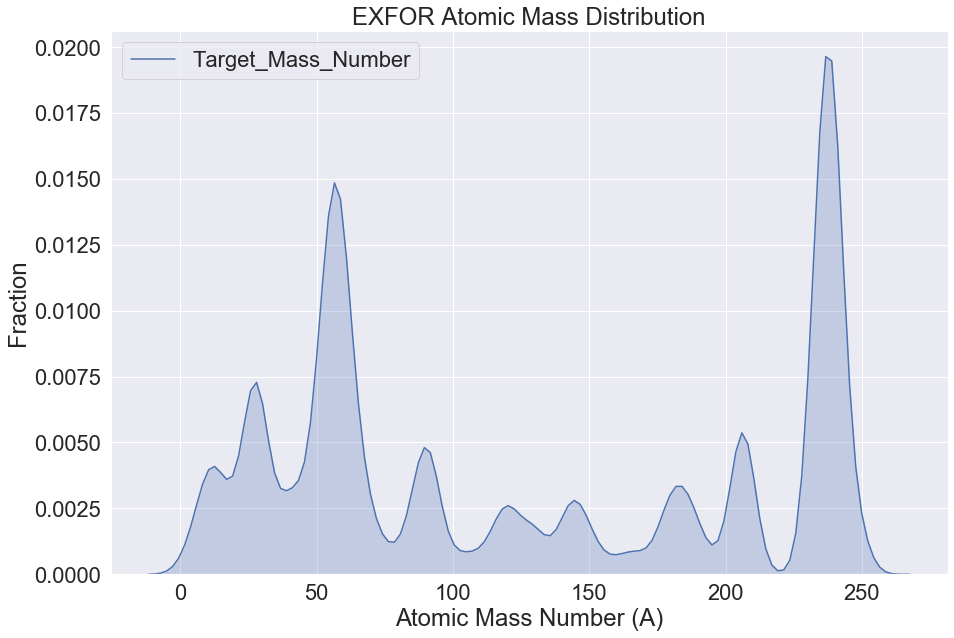

In [41]:
plt.figure(figsize=(15,10))
g = sns.kdeplot(df.Target_Mass_Number, shade=True);
g.set(xlabel="Atomic Mass Number (A)", ylabel="Fraction")
plt.title("EXFOR Atomic Mass Distribution")
plt.savefig(figure_dir + 'EXFOR_Atomic_Mass_Dist.png', bbox_inches='tight')

# Institute, Reaction Types, and Isotopes

We can see by the distributions that the majority of the measurments have been made at Oak Ridge National Laboratory's LINAC facility. 

The majority of the measurments in the EXFOR dataset are (n,tot) followed by (n,g) and (n,f). Other reaction types that have been measured are Inelastic and Elastic Scattering and in lesser extent (n,p) and (n,a) reaciton types.

As for Isotopes, Fe-56, Pu-239, U-235, 238U 233U Al-27 Np-237, 91Zr cover the majority of the measruments here.

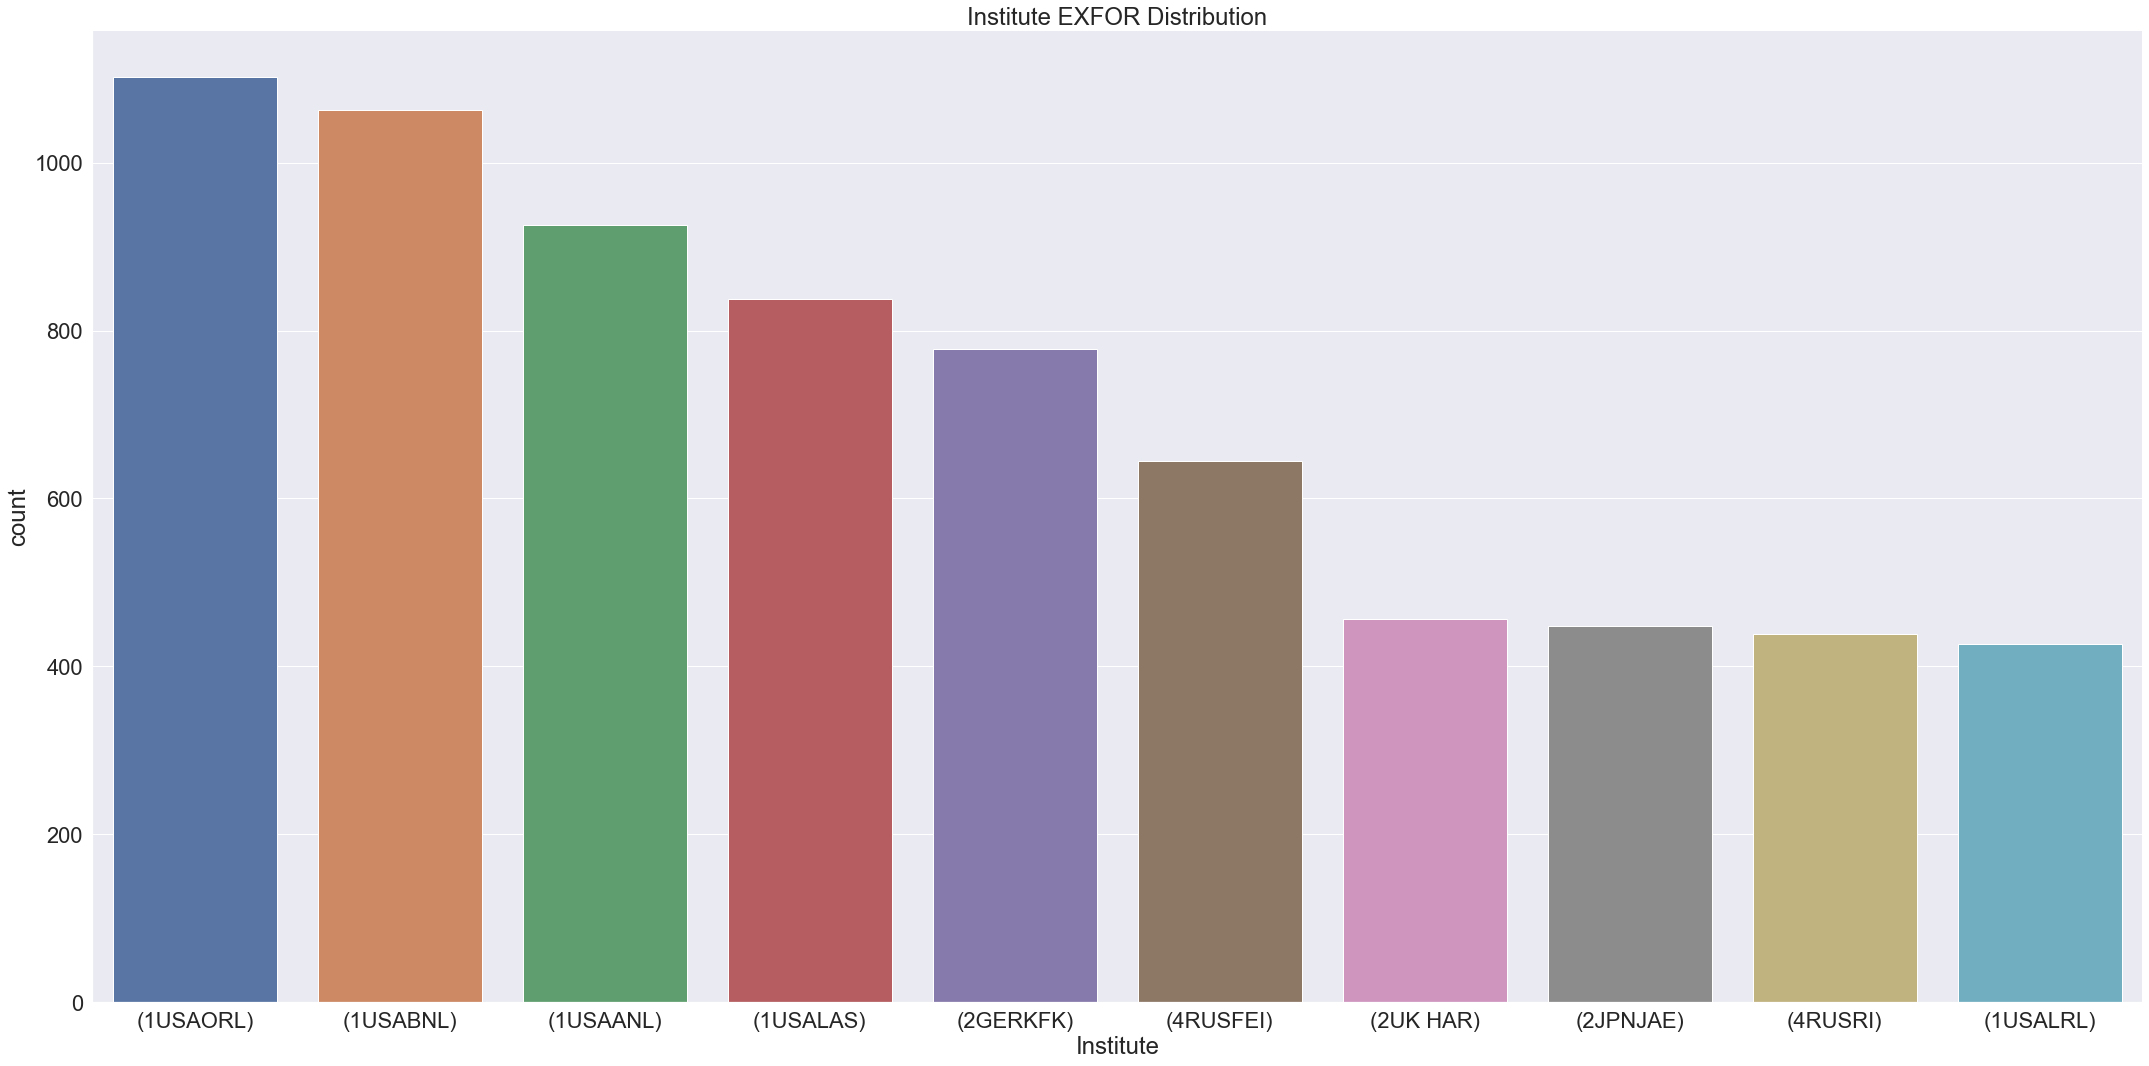

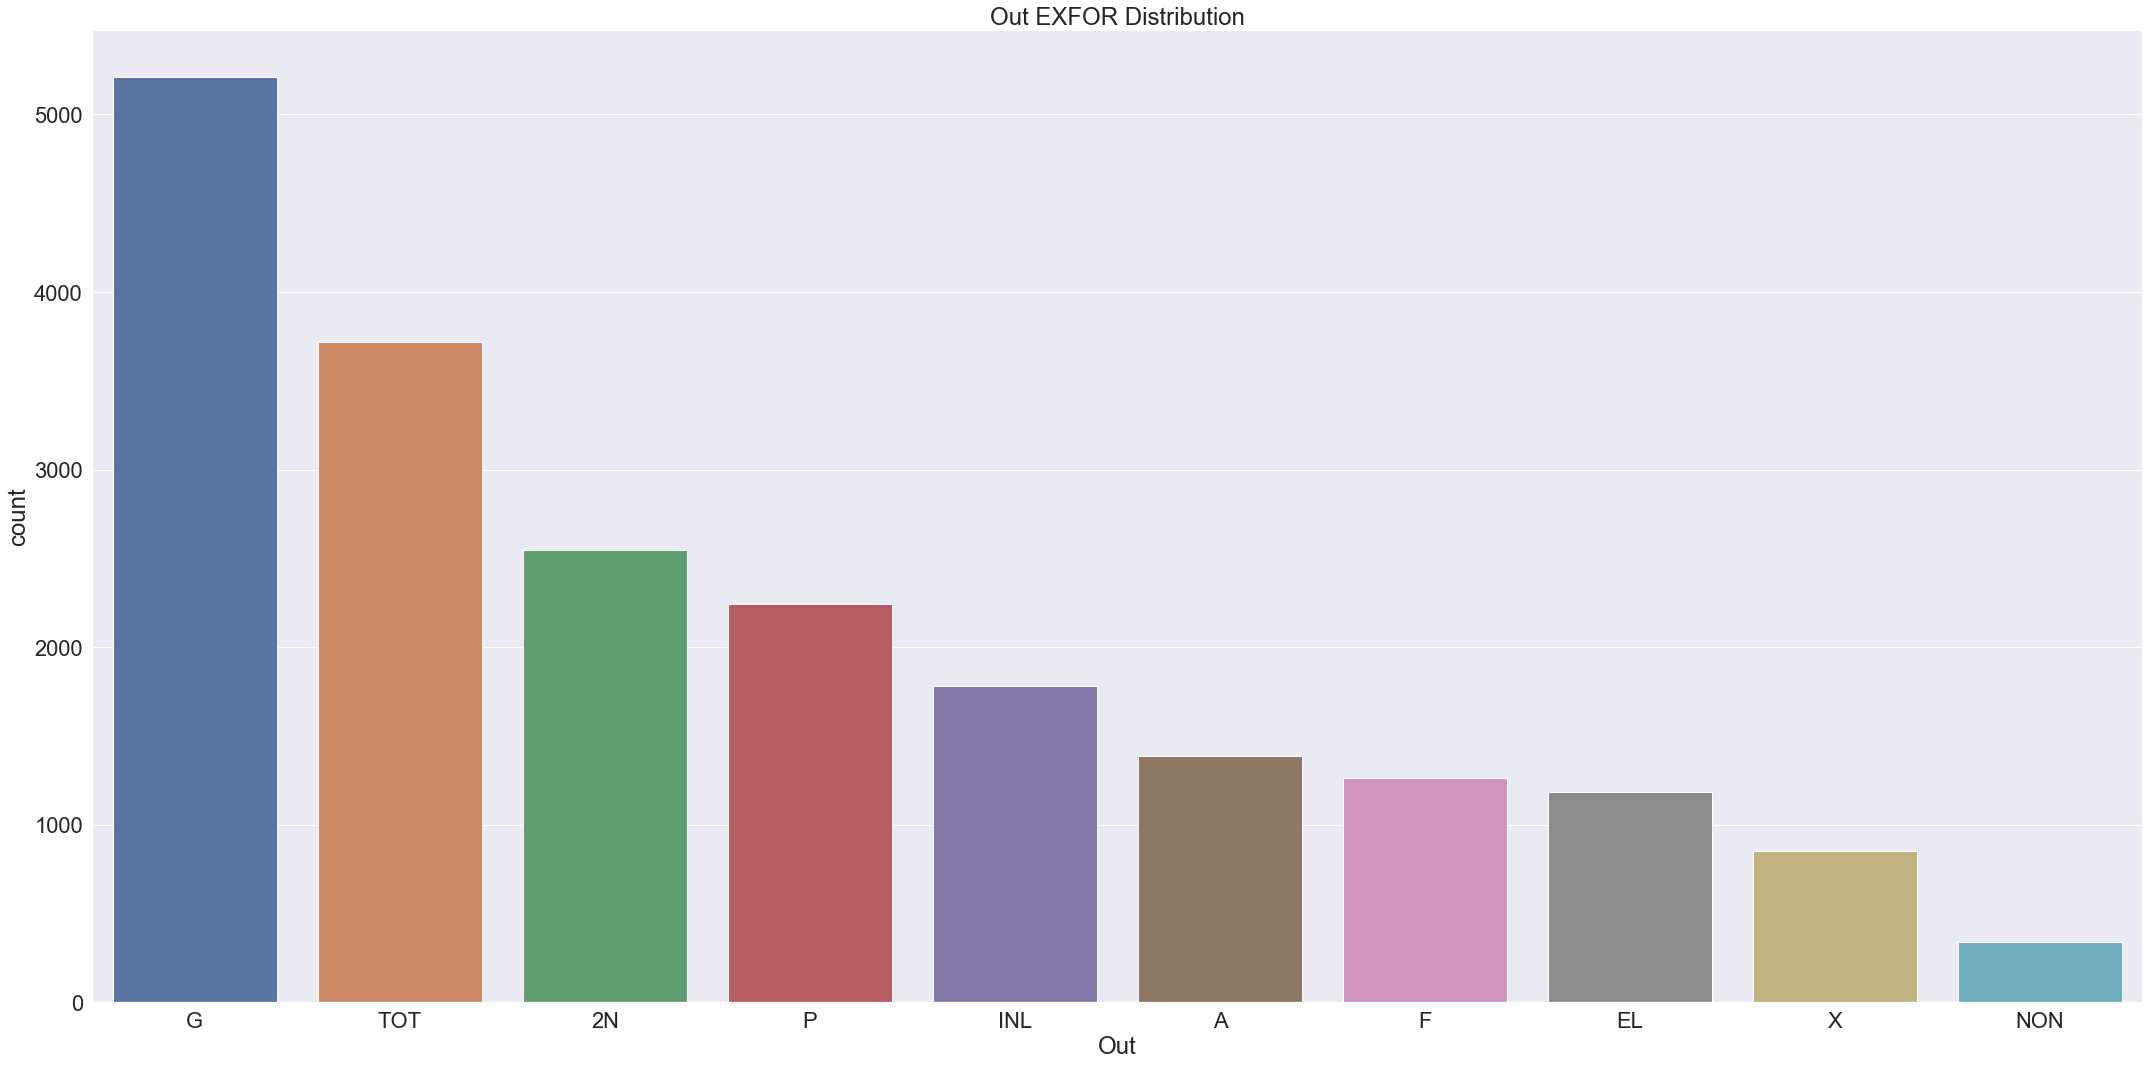

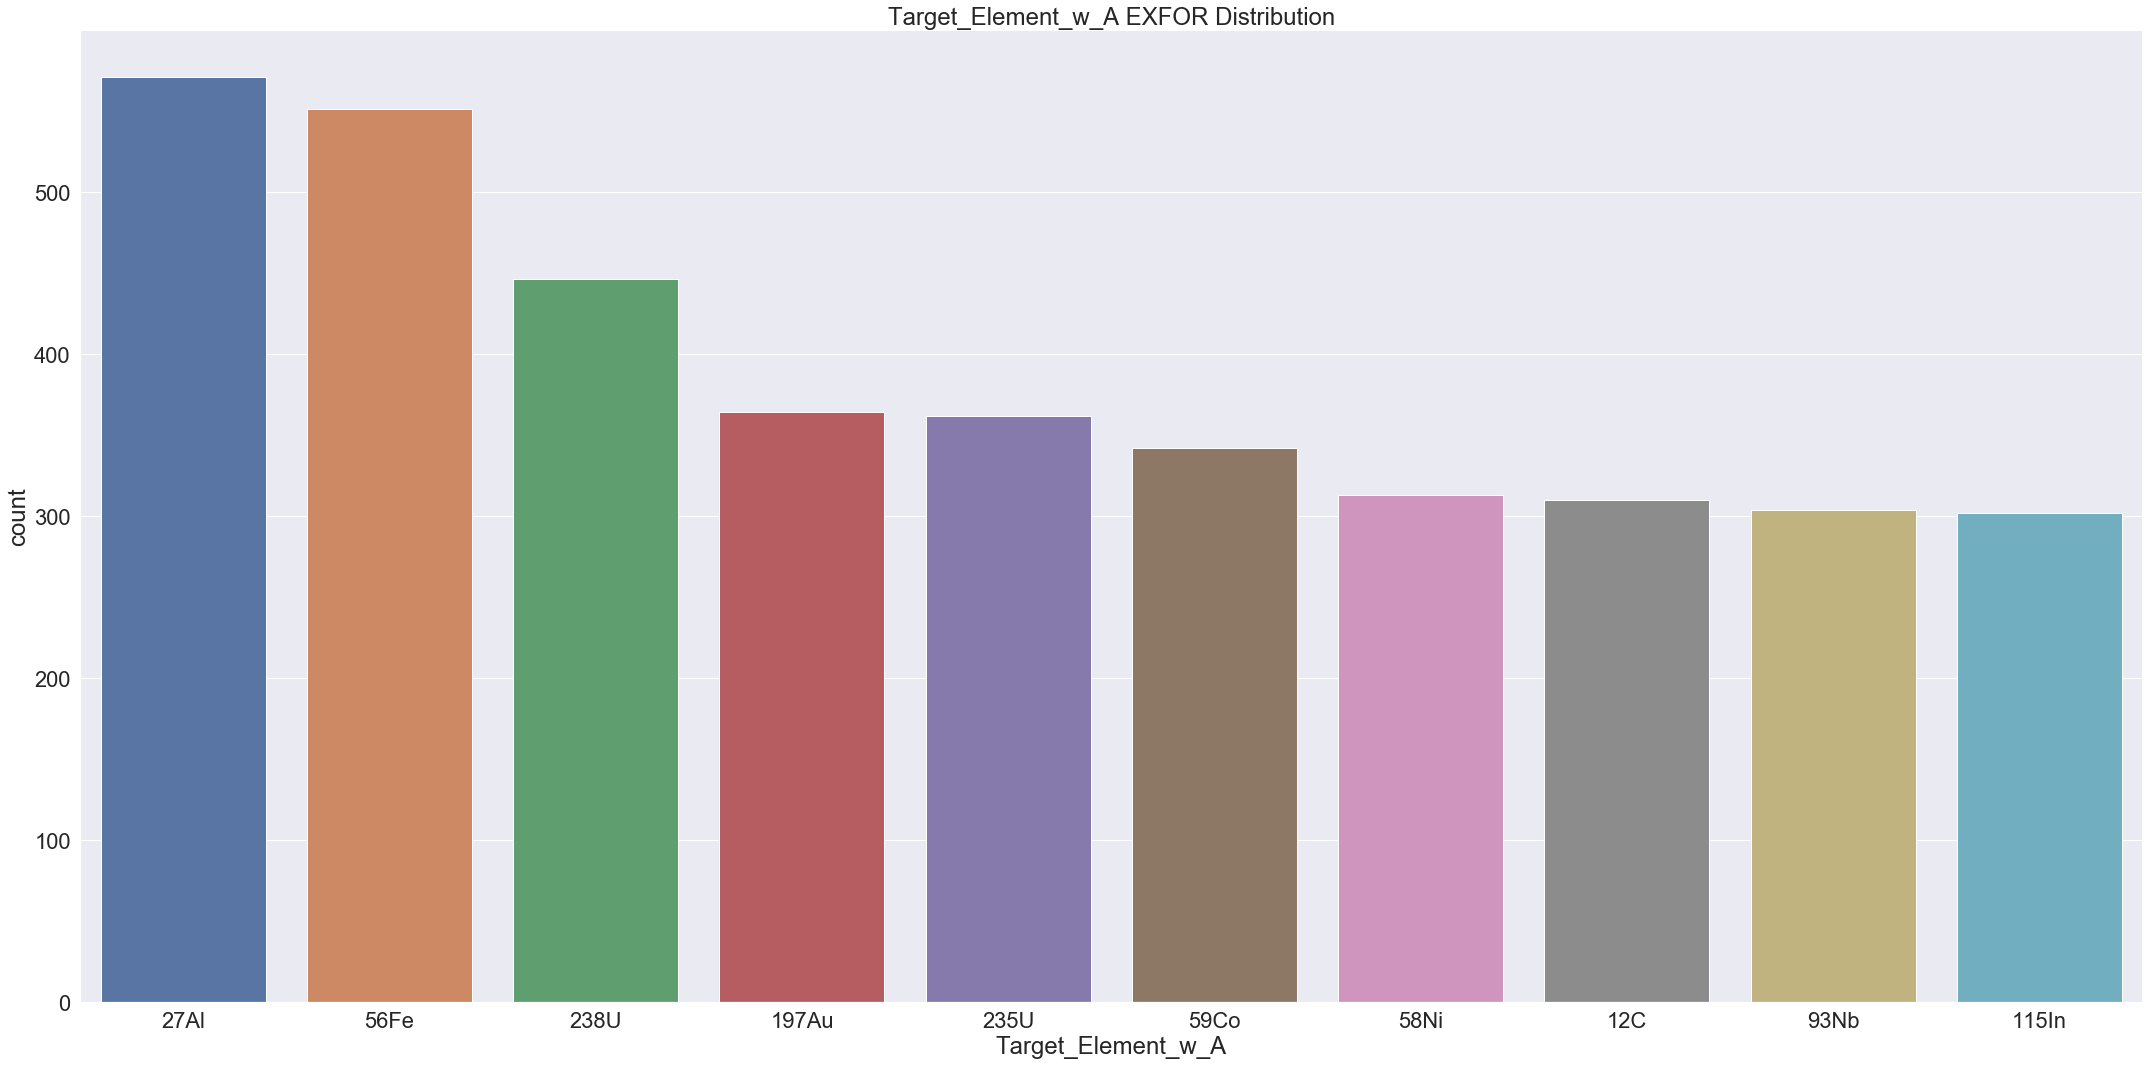

In [109]:
cat_cols_plot = ["Institute", "Out", "Target_Element_w_A"]
for i in cat_cols_plot:
    for_plotting = df[[i, "Reference"]].drop_duplicates()
    sns.catplot(x=i, kind="count", data=for_plotting, 
            order=for_plotting[i].value_counts().iloc[:10].index, 
            palette="deep", height=15, aspect=2);
    plt.title("{} EXFOR Distribution".format(i))
    plt.savefig(figure_dir + 'EXFOR_{}.png'.format(i), bbox_inches='tight')

# Energy Distribution (thermal or fast measruments?), Year

In [17]:
sns.set(font_scale=1)

In [18]:
campaigns = df[['Year', 'Title']].groupby(['Year']).agg(['count']).reset_index().sort_values(by="Year")
campaigns.columns = ["Year", "Counts"]

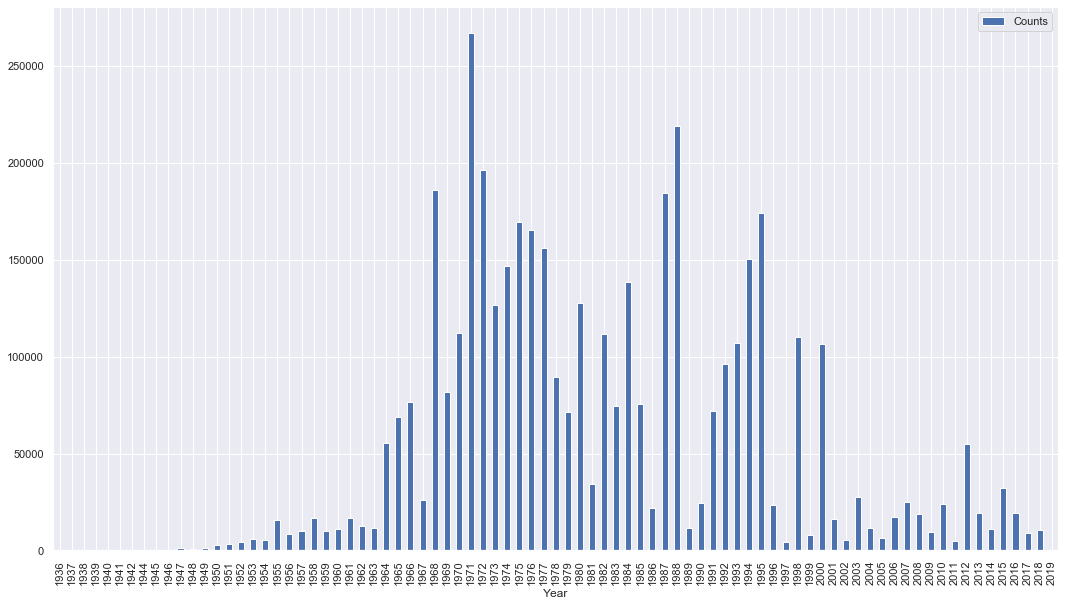

In [20]:
campaigns.plot(x="Year", y="Counts", kind='bar', figsize=(18,10))
plt.savefig(figure_dir + 'EXFOR_experiments_year.png', bbox_inches='tight')

In [21]:
energy = ((10**df.sort_values(by="Energy").Energy) * 1E-6)
energy_l15 = energy[energy < 15]

In [27]:
sns.set(font_scale=2)

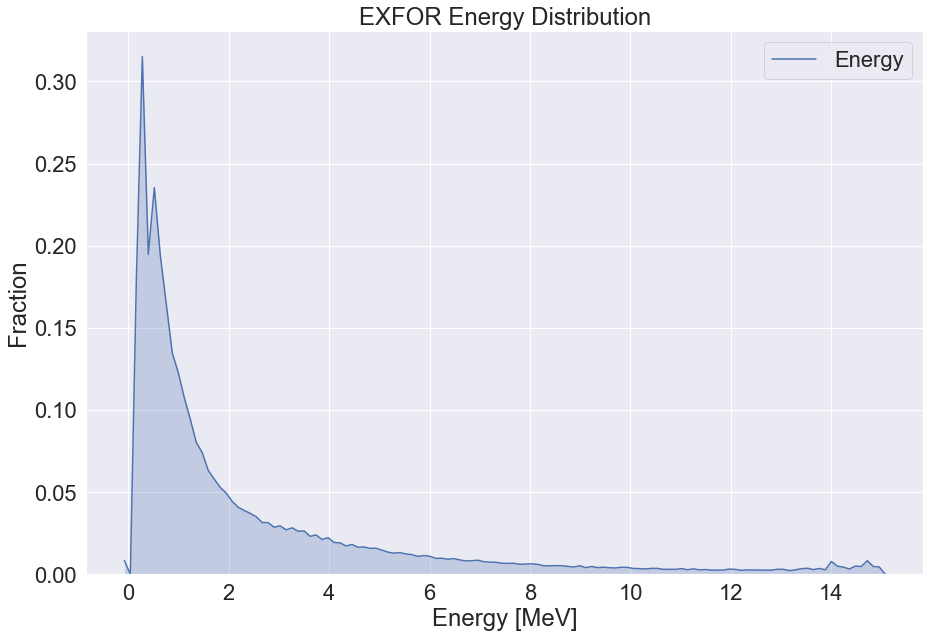

In [29]:
plt.figure(figsize=(15,10))
g = sns.kdeplot(energy_l15, shade=True);
g.set(xlabel="Energy [MeV]", ylabel="Fraction")
plt.title("EXFOR Energy Distribution")
plt.savefig(figure_dir + 'EXFOR_Energy_Dist.png', bbox_inches='tight')

# Iron and Chlorine Energy Distribution

In [23]:
iron56 = df[(df["Target_Protons"] == 26) & (df["MT"] == 102) & (df["Target_Mass_Number"] == 56)].sort_values(
        by='Energy', ascending=False)

energy_iron = ((10**iron56.sort_values(by="Energy").Energy) * 1E-6)

chlorine35 = df[(df["Target_Protons"] == 17) & (df["MT"] == 103) & (df["Target_Mass_Number"] == 35)].sort_values(
        by='Energy', ascending=False)

energy_cl = ((10**chlorine35.sort_values(by="Energy").Energy) * 1E-6)

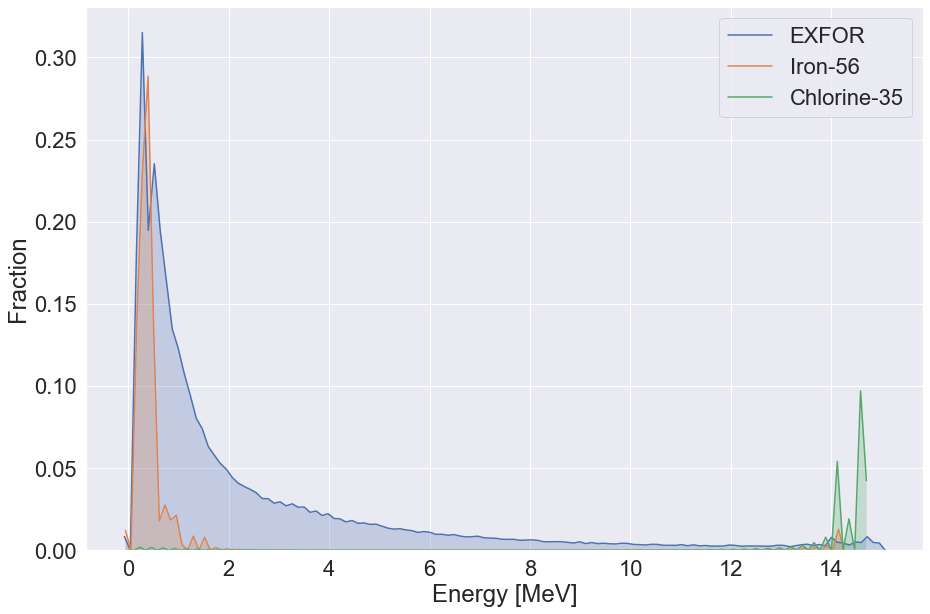

In [32]:
plt.figure(figsize=(15,10))
sns.kdeplot(energy_l15, shade=True, label="EXFOR");
sns.kdeplot(energy_iron, shade=True, label="Iron-56");
sns.kdeplot(energy_cl, shade=True, label="Chlorine-35");
plt.xlabel("Energy [MeV]") 
plt.ylabel("Fraction")
plt.savefig(figure_dir + 'EXFOR_Cl_Fe_Energy_Dist.png', bbox_inches='tight')

In [14]:
sns.set(font_scale=1)

In [24]:
def plot_exfor(MT, Z, M, nat_iso="I", additional_data=pd.DataFrame(), endf=pd.DataFrame(), save=False, interpolate=False, legend=True, alpha=0.7):
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Target_Protons"] == Z) & (df["MT"] == MT) & (df["Target_Mass_Number"] == M)
                 & (df["Target_Flag"] == nat_iso)].sort_values(by='Energy', ascending=False)
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    fg = sns.FacetGrid(data=to_plot[["Energy", "Data", "Reference"]], hue='Reference', 
                       hue_order=to_plot["Reference"].unique(), aspect=1.5, legend_out=False, height=10)
    fg.map(plt.scatter, "Energy", "Data", alpha=alpha)

    if legend == True:
        fg.add_legend()
        if interpolate == True:
            sns.lineplot(to_plot["Energy"], to_plot["Data"], alpha=alpha*0.5, label="Interpolation", ci=None)
        if endf.shape[0] != 0:
            sns.lineplot(endf["Energy"], endf["Data"], c="g", label="ENDF", alpha=alpha, ci=None)
        if additional_data.shape[0] != 0:
            sns.scatterplot(additional_data["Energy"], additional_data["Data"], color="r", 
                            alpha=0.5, label="New Data", ci=None)   

    if legend == False:
        if interpolate == True:
            sns.lineplot(to_plot["Energy"], to_plot["Data"], alpha=alpha*0.5, legend=False, ci=None)
        if endf.shape[0] != 0:
            sns.lineplot(endf["Energy"], endf["Data"], c="orange", alpha=1.0, legend=False, ci=None)
        if additional_data.shape[0] != 0:
            sns.scatterplot(additional_data["Energy"], additional_data["Data"], legend=False, ci=None)  
        
        
    plt.title("{} MT = {}".format(to_plot.Target_Element_w_A.values[0], MT))
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    plt.yscale('log')
    
    if (additional_data.shape[0] != 0 and endf.shape[0] != 0): #if both 
        all_y = np.concatenate((to_plot["Data"], endf["Data"], additional_data["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] == 0 and endf.shape[0] !=0: # if ENDF only
        all_y = np.concatenate((to_plot["Data"], endf["Data"]))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    elif additional_data.shape[0] != 0 and endf.shape[0] == 0: # if ADDITIONAL only
        all_y = np.concatenate((to_plot["Data"].values, additional_data["Data"].values))
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)
    else: # if no ENDF and Additional  
        all_y = to_plot["Data"].values
        minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
        maximum_y = all_y.max() + all_y.max() * 0.05
        plt.ylim(minimum_y, maximum_y)

    plt.xscale('log')
    if save == True:
        plt.savefig(figure_dir + "EXFOR_{}_XS.png".format(to_plot.Target_Element_w_A.values[0]), bbox_inches='tight')

<Figure size 1152x720 with 0 Axes>

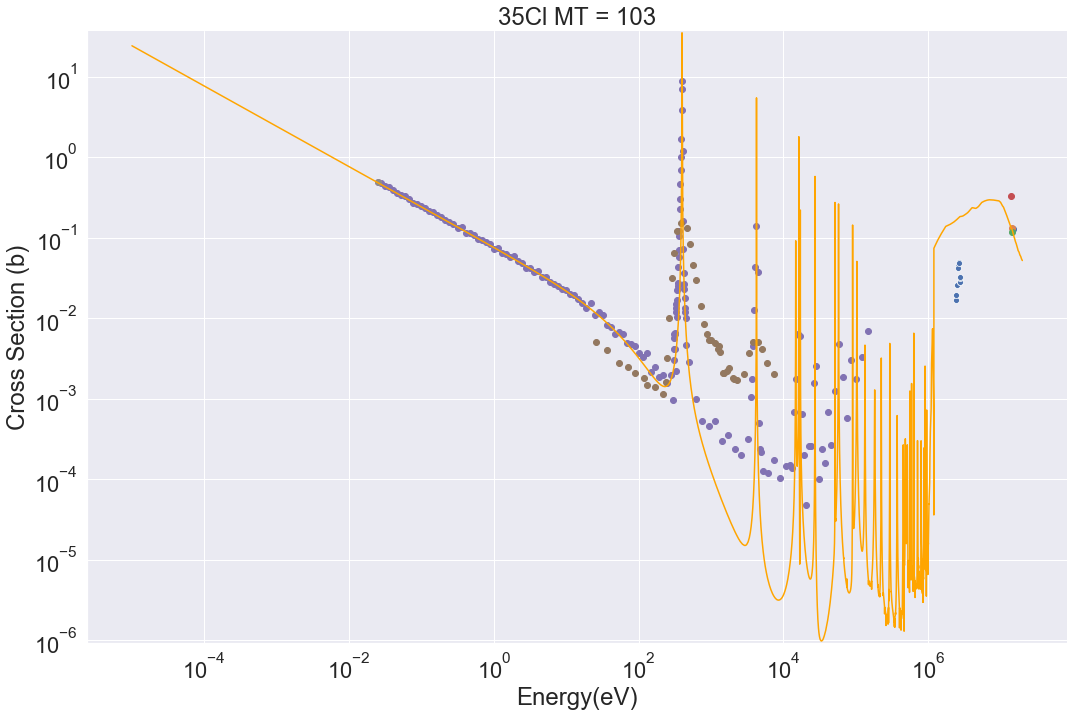

In [25]:
plot_exfor(103, 17, 35, additional_data=new_data, endf=endf_all, legend=False, save=True, alpha=1)

<Figure size 1152x720 with 0 Axes>

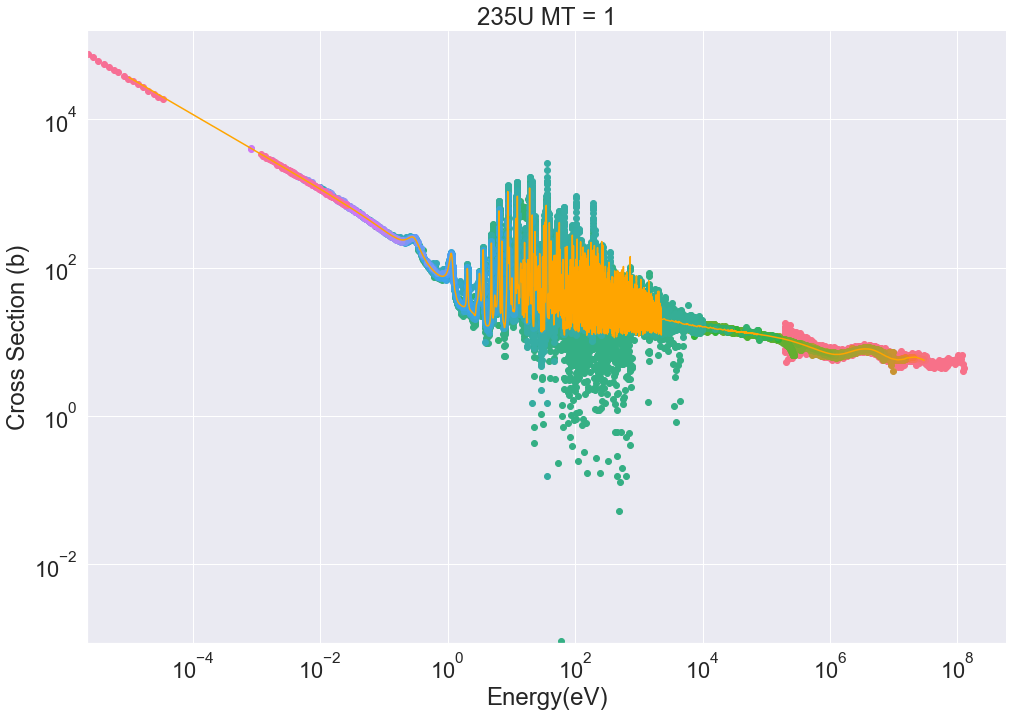

In [22]:
plot_exfor(1, 92, 235, nat_iso="I", endf=endf_u, legend=False, save=False, alpha=1)

# Numerical Features

Lets follow up with the Chlorine-35 (n,p) example.

In [65]:
uranium = df[(df["Target_Protons"] == 92) & (df["MT"] == 1) & (df["Target_Mass_Number"] == 235)].sort_values(
    by='Energy', ascending=False)

In [115]:
chlorine = df[(df["Target_Protons"] == 17) & (df["MT"] == 103) & (df["Target_Mass_Number"] == 35)].sort_values(by='Energy', ascending=False)

In [117]:
chlorine.describe()

,Energy,dEnergy,Data,dData,ELV/HL,dELV/HL,Target_Protons,Year,Date,Target_Neutrons,Target_Mass_Number,Target_Radius,Target_Neut_Rad_Ratio,Target_Mass_Excess,Target_dMass_Excess,Target_Binding_Energy,Target_dBinding_Energy,Target_B_Decay_Energy,Target_dB_Decay_Energy,Target_Atomic_Mass_Micro,Target_dAtomic_Mass_Micro,Target_S(2n),Target_dS(2n),Target_S(2p),Target_dS(2p),Target_S(n),Target_dS(n),Target_S(p),Target_dS(p),Compound_Neutrons,Compound_Mass_Number,Compound_Protons,Compound_Mass_Excess,Compound_dMass_Excess,Compound_Binding_Energy,Compound_dBinding_Energy,Compound_B_Decay_Energy,Compound_dB_Decay_Energy,Compound_Atomic_Mass_Micro,Compound_dAtomic_Mass_Micro,Compound_S(2n),Compound_dS(2n),Compound_S(2p),Compound_dS(2p),Compound_S(n),Compound_dS(n),Compound_S(p),Compound_dS(p)
count,2.160000e+02,216.000000,216.000000,216.000000,216.0,216.0,216.0,216.000000,2.160000e+02,216.0,216.0,2.160000e+02,2.160000e+02,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,2.160000e+02,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.0,216.0,216.0,216.000,2.160000e+02,2.160000e+02,2.160000e+02,216.000,2.160000e+02,2.160000e+02,2.160000e+02,2.160000e+02,216.00,216.00,2.160000e+02,2.160000e+02,216.0,2.160000e+02,2.160000e+02
mean,2.746206e+05,3331.131388,0.168940,0.010491,0.0,0.0,17.0,1984.662037,1.993674e+07,18.0,35.0,4.088833e+00,1.956549e-01,-28940.556340,0.901059,8518.131541,0.021770,-5916.991437,1.645520,3.497109e+07,0.967523,24119.670213,1.485549,17280.916168,2.250758,12626.248752,1.180578,6386.111274,1.187365,19.0,36.0,17.0,-29522.005,3.600000e-02,8.521931e+03,1.000000e-03,709.535,4.500000e-02,3.596831e+07,3.800000e-02,2.122456e+04,0.05,19551.25,8.100000e-01,8.579790e+03,0.0,7.964770e+03,3.000000e-02
std,1.958895e+06,23749.179229,0.812348,0.053155,0.0,0.0,0.0,12.371071,4.075400e+04,0.0,0.0,1.780483e-15,5.564010e-17,1072.459992,12.728416,31.546375,0.305251,723.847195,14.204891,3.294205e+04,13.661145,487.347356,16.101220,393.821631,17.059583,272.058672,16.616031,224.881885,16.862755,0.0,0.0,0.0,0.000,1.391002e-17,3.646429e-12,4.346883e-19,0.000,6.955012e-18,1.493577e-08,6.955012e-18,3.646429e-12,0.00,0.00,3.338406e-16,3.646429e-12,0.0,2.734822e-12,1.043252e-17
min,2.530000e-02,0.000261,0.000048,0.000048,0.0,0.0,17.0,1961.000000,1.992020e+07,18.0,35.0,4.088833e+00,1.956549e-01,-29013.528000,0.035000,8056.642875,0.001000,-5966.243000,0.679000,3.496885e+07,0.038000,16990.315909,0.390000,17254.120000,1.090000,8646.330435,0.050000,6370.810000,0.040000,19.0,36.0,17.0,-29522.005,3.600000e-02,8.521931e+03,1.000000e-03,709.535,4.500000e-02,3.596831e+07,3.800000e-02,2.122456e+04,0.05,19551.25,8.100000e-01,8.579790e+03,0.0,7.964770e+03,3.000000e-02
25%,1.845750e+01,0.261210,0.002100,0.000380,0.0,0.0,17.0,1991.000000,1.992020e+07,18.0,35.0,4.088833e+00,1.956549e-01,-29013.528000,0.035000,8520.278000,0.001000,-5966.243000,0.679000,3.496885e+07,0.038000,24152.830000,0.390000,17254.120000,1.090000,12644.760000,0.050000,6370.810000,0.040000,19.0,36.0,17.0,-29522.005,3.600000e-02,8.521931e+03,1.000000e-03,709.535,4.500000e-02,3.596831e+07,3.800000e-02,2.122456e+04,0.05,19551.25,8.100000e-01,8.579790e+03,0.0,7.964770e+03,3.000000e-02
50%,3.511000e+02,6.011867,0.010100,0.001350,0.0,0.0,17.0,1991.000000,1.992020e+07,18.0,35.0,4.088833e+00,1.956549e-01,-29013.528000,0.035000,8520.278000,0.001000,-5966.243000,0.679000,3.496885e+07,0.038000,24152.830000,0.390000,17254.120000,1.090000,12644.760000,0.050000,6370.810000,0.040000,19.0,36.0,17.0,-29522.005,3.600000e-02,8.521931e+03,1.000000e-03,709.535,4.500000e-02,3.596831e+07,3.800000e-02,2.122456e+04,0.05,19551.25,8.100000e-01,8.579790e+03,0.0,7.964770e+03,3.000000e-02
75%,2.382000e+03,21.926103,0.073650,0.003500,0.0,0.0,17.0,1991.000000,1.992020e+07,18.0,35.0,4.088833e+00,1.956549e-01,-29013.528000,0.035000,8520.278000,0.001000,-5966.243000,0.679000,3.496885e+07,0.038000,24152.830000,0.390000,17254.120000,1.090000,12644.760000,0.050000,6370

We can explor correlation among features but as we know beforehand, cross section do not behave linearly. Let us use the chlorine 35 n,p cross sections as an example.

In [118]:
pd.DataFrame(chlorine.corr()).sort_values(by='Data', ascending=False).head()

,Energy,dEnergy,Data,dData,ELV/HL,dELV/HL,Target_Protons,Year,Date,Target_Neutrons,Target_Mass_Number,Target_Radius,Target_Neut_Rad_Ratio,Target_Mass_Excess,Target_dMass_Excess,Target_Binding_Energy,Target_dBinding_Energy,Target_B_Decay_Energy,Target_dB_Decay_Energy,Target_Atomic_Mass_Micro,Target_dAtomic_Mass_Micro,Target_S(2n),Target_dS(2n),Target_S(2p),Target_dS(2p),Target_S(n),Target_dS(n),Target_S(p),Target_dS(p),Compound_Neutrons,Compound_Mass_Number,Compound_Protons,Compound_Mass_Excess,Compound_dMass_Excess,Compound_Binding_Energy,Compound_dBinding_Energy,Compound_B_Decay_Energy,Compound_dB_Decay_Energy,Compound_Atomic_Mass_Micro,Compound_dAtomic_Mass_Micro,Compound_S(2n),Compound_dS(2n),Compound_S(2p),Compound_dS(2p),Compound_S(n),Compound_dS(n),Compound_S(p),Compound_dS(p)
Data,0.000392,-0.001125,1.000000,0.993708,NaN,NaN,NaN,0.090526,-0.026421,NaN,NaN,1.496698e-17,7.972726e-18,0.016919,0.016919,-0.016919,0.016919,0.016919,0.016919,0.016919,0.016919,-0.016919,0.016919,0.016919,0.016919,-0.016919,0.016919,0.016919,0.016919,NaN,NaN,NaN,2.293246e-17,5.129926e-17,-3.231052e-17,-5.707747e-18,-5.707747e-18,-6.167538e-17,-2.293246e-17,-1.600121e-17,6.167538e-17,-5.707747e-18,NaN,3.230162e-17,-1.600121e-17,NaN,6.167538e-17,-1.600121e-17
dData,0.039680,0.037766,0.993708,1.000000,NaN,NaN,NaN,0.069616,-0.000872,NaN,NaN,-2.653207e-16,2.538979e-16,0.012228,0.012228,-0.012228,0.012228,0.012228,0.012228,0.012228,0.012228,-0.012228,0.012228,0.012228,0.012228,-0.012228,0.012228,0.012228,0.012228,NaN,NaN,NaN,-2.958992e-16,2.336868e-16,-2.757142e-16,-2.945989e-16,-2.945989e-16,2.980315e-16,2.958992e-16,-2.761311e-16,-2.980315e-16,-2.945989e-16,NaN,-3.117619e-16,-2.761311e-16,NaN,-2.980315e-16,-2.761311e-16
Year,-0.170847,-0.172947,0.090526,0.069616,NaN,NaN,NaN,1.000000,-0.534500,NaN,NaN,-6.823022e-15,6.823022e-15,0.117906,0.117906,-0.117906,0.117906,0.117906,0.117906,0.117906,0.117906,-0.117906,0.117906,0.117906,0.117906,-0.117906,0.117906,0.117906,0.117906,NaN,NaN,NaN,-7.662254e-15,6.033320e-15,-5.970144e-15,-6.823022e-15,-6.823022e-15,6.823022e-15,7.662254e-15,-7.229779e-15,-6.823022e-15,-6.823022e-15,NaN,-6.117976e-15,-7.229779e-15,NaN,-6.823022e-15,-7.229779e-15
Target_S(p),-0.009583,-0.009588,0.016919,0.012228,NaN,NaN,NaN,0.117906,0.308570,NaN,NaN,1.447477e-13,-1.439605e-13,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.440961e-13,-1.445214e-13,1.441558e-13,1.441196e-13,1.441196e-13,-1.443386e-13,-1.440961e-13,1.445825e-13,1.443386e-13,1.441196e-13,NaN,1.444724e-13,1.445825e-13,NaN,1.443386e-13,1.445825e-13
Target_dBinding_Energy,-0.009583,-0.009588,0.016919,0.012228,NaN,NaN,NaN,0.117906,0.308570,NaN,NaN,-1.728254e-16,1.543084e-16,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.382603e-16,-2.400352e-16,1.932915e-16,-3.150462e-16,-3.150462e-16,1.350198e-16,-1.382603e-16,-2.160317e-16,-1.350198e-16,-3.150462e-16,NaN,-5.760846e-17,-2.160317e-16,NaN,-1.350198e-16,-2.160317e-16


<b>P-value</b>: 
<p>What is this P-value? The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant.</p>

By convention, when the
<ul>
    <li>p-value is $<$ 0.001: we say there is strong evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.05: there is moderate evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.1: there is weak evidence that the correlation is significant.</li>
    <li>the p-value is $>$ 0.1: there is no evidence that the correlation is significant.</li>
</ul>

In [120]:
from scipy import stats

In [121]:
pearson_coef, p_value = stats.pearsonr(chlorine['Energy'], chlorine['Data'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.00039191327732860607  with a P-value of P = 0.9954309362611046


The energy is weakley linearly correlated. The p-value results in 1% confidence that this correlation is significant. We therefore expect that a linear model will work poorly in this data. As a nuclear engineer, we know that there are depedences on Energy depending on the region. One solution could be to split the data into the appropiate energy ranges but that would defeat the purpose of this project.

In [347]:
num_columns = []
for col in list(df.columns):
    if col not in str_cols:
        num_columns.append(col)

In [330]:
fig, ax = plt.subplots(figsize=(25,30))
to_plot[num_columns].hist(ax=ax)
plt.savefig(figure_dir + 'example.svg')  
plt.close(fig)

C:\Users\Pedro\Anaconda3\envs\data_mining_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


We can see that several features are extremeley negatively skewed. This introduces problems to almost all ML algorithms as we shall demonstrate in the next notebook. 

In [331]:
from scipy.stats import skew

- skewness = 0 : normally distributed.
- skewness > 0 : more weight in the left tail of the distribution.
- skewness < 0 : more weight in the right tail of the distribution.

In [349]:
num_cols_real = []

In [350]:
num_cols_real.extend(num_columns[:17])
num_cols_real.extend(num_columns[-4:])

In [352]:
case_list = {}

for col in num_cols_real:
    skewness = skew(to_plot[col].values)
    case = {col: skewness}
    case_list.update(case)
    
skew_df = pd.Series(case_list).to_frame().reset_index()
skew_df.columns = ["Column_Name", "Skewness"]
skew_df = skew_df.sort_values(by=["Skewness"], ascending=False)

In [353]:
skew_df

,Column_Name,Skewness
13,B_Decay_Energy,14.594679
14,dB_Decay_Energy,14.594679
10,dMass_Excess,14.594679
12,dBinding_Energy,14.594679
16,dAtomic_Mass_Micro,14.594679
9,Mass_Excess,14.594679
2,Data,8.629346
3,dData,8.604344
6,Date,3.855392
17,Nuc_Radius_fm,1.000000


In [234]:
# In addition to all uncertanties
# skewed_cols = ["Binding_Energy", "ELV/HL", "Energy", "dBinding_Energy", "dELV/HL", "dEnergy"]
skewed_cols = ["Energy", "dEnergy"]

In [14]:
energy_log = np.log10(df["Energy"].values)
energy_ln = np.log(df["Energy"].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000190D1AAB1D0>]],
      dtype=object)

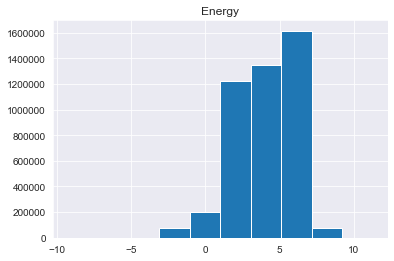

In [235]:
df[["Energy"]].hist()

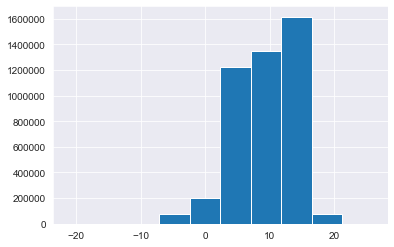

In [17]:
plt.hist(energy_ln)
plt.show()

In [18]:
for col in skewed_cols:
    log_values = np.log10(df[col].values)
    df[col] = log_values

In [23]:
df["Year"] = df["Year"].astype(int)

# Categorical Data

<h3>ANOVA: Analysis of Variance</h3>
<p>The Analysis of Variance  (ANOVA) is a statistical method used to test whether there are significant differences between the means of two or more groups. ANOVA returns two parameters:</p>

<p><b>F-test score</b>: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.</p>

<p><b>P-value</b>:  P-value tells how statistically significant is our calculated score value.</p>

<p>If our data variable is strongly correlated with the variable we are analyzing, expect ANOVA to return a sizeable F-test score and a small p-value.</p>

In [14]:
grouped_test = df[['MT', 'Data']].groupby(['MT'])

f_val, p_val = stats.f_oneway(grouped_test.get_group("1")['Data'], grouped_test.get_group('101')['Data'], grouped_test.get_group('102')['Data'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 15917.016298247428 , P = 0.0


This is a great result, with a large F test score showing a strong correlation and a P value of almost 0 implying almost certain statistical significance. But does this mean all three tested groups are all this highly correlated? 

In [354]:
def box_plot(x, dataframe=df, figsize=(8,6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=x, y="Data", data=dataframe)

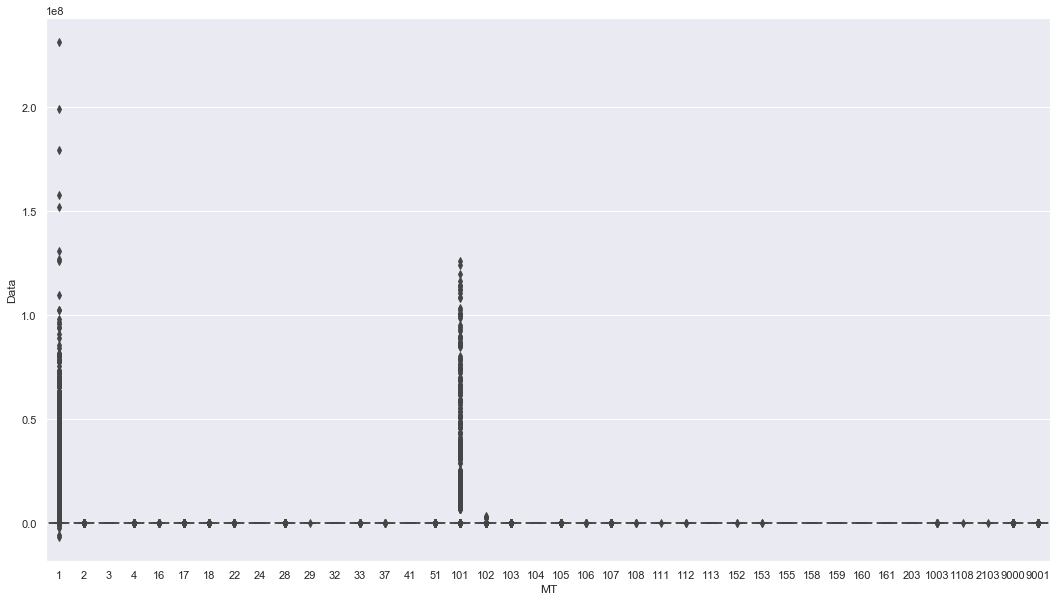

In [355]:
box_plot("MT", figsize=(18,10))

The values for other reaction types get squashed do the large magnitude of fission and total cross section data points (MT1 and MT101). Still it is noticable that these cross sections are magnitudes higher than other types. This feature will be helpful in determining limits to some reaction types (it will learn not to go above certan values.

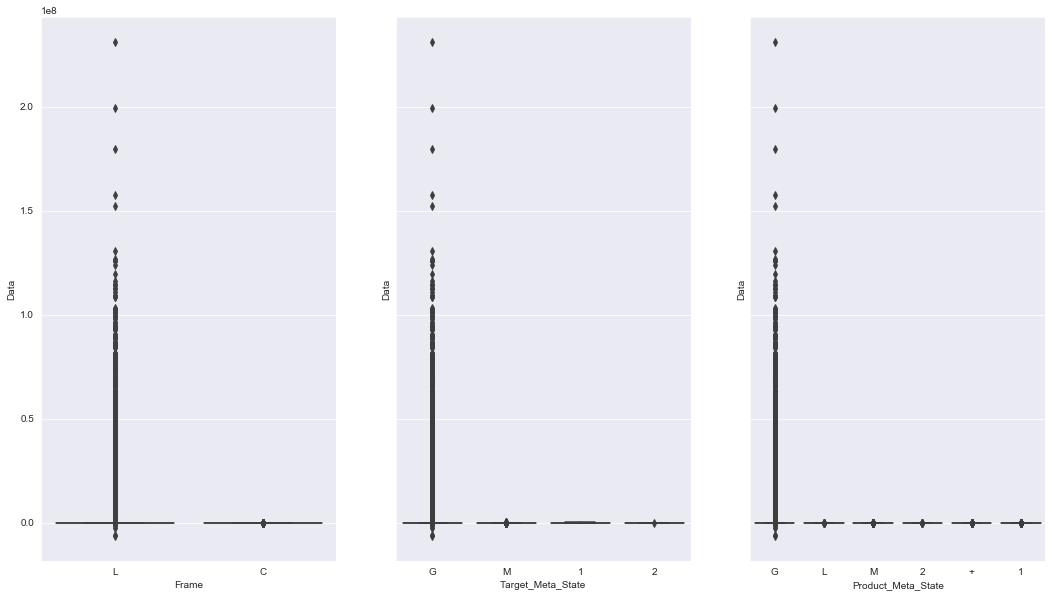

In [18]:
# call regplot on each axes
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(18,10))
sns.boxplot(x="Frame", y="Data", data=df, ax=ax1)
sns.boxplot(x="Target_Meta_State", y="Data", data=df, ax=ax2)
sns.boxplot(x="Product_Meta_State", y="Data", data=df, ax=ax3)